In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
warnings.resetwarnings()

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# CNN COVID-19 case number forecasting.

<!-- <img src="files/architecture2.png"> -->

# CNN Architecture

![title](conv_architecture.jpg)

# Function Declarations

In [102]:
def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    # can't include the max date because need at least 1 day in future to predict. +1 because of how range doesn't include endpoint
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 1):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window) & 
                                (time_index > max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    # y = model_data.new_cases_weighted.values.reshape(-1, model_data.time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, date_normalization=True,
                          train_test_only=False):
    """ Split into training, validation and test data.
    """

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)
                   
    return splits


def minmax(X, X_min, X_max):
    # X_min and X_max need to have already been made into 4-d tensors with np.newaxis
    tile_shape = np.array(np.array(X.shape) / np.array(X_min.shape), dtype=int)
    denominator = np.tile(X_max, tile_shape) - np.tile(X_min, tile_shape)
    denominator[denominator==0] = 1
    X_scaled = (X - np.tile(X_min, tile_shape)) / denominator
    return X_scaled

def normal(X, X_mean, X_std):
    tile_shape = np.array(np.array(X.shape) / np.array(X_mean.shape), dtype=int)
    mean_ = np.tile(X_mean, tile_shape)
    std_ =  np.tile(X_std, tile_shape)   
    std_[np.where(std_==0.)] = 1
    X_scaled = ((X - mean_) /  std_)
    return X_scaled

def normalize_Xy_splits(splits, normalization_method='minmax', train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    """
    min_, max_ = (0, 1)
    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits

    if normalization_method=='minmax':
        # To encapsulate the time-dependent nature of the problem and ignore the dramatic difference between current
        # and initial behavior, only rescale the validation and testing frames by the most recent frame's values.
        # There is only a single value per feature in this case, meaning that to rescale, the values need to
        # be repeated for each validation, test frame for each country for each timestep.
        X_min = X_train.min(axis=(2))
        X_max = X_train.max(axis=(2))


        X_train_scaled = minmax(X_train, X_min[:, :, np.newaxis, :],
                        X_max[:, :, np.newaxis, :])
        X_test_scaled = minmax(X_test, X_min[-1][np.newaxis, :, np.newaxis, :], 
                               X_max[-1][np.newaxis, :, np.newaxis, :])
        if train_test_only:
        # Normalize the training data by each frame's specific mean and std deviation. 
            splits = (X_train_scaled, y_train, X_test_scaled, y_test)
        else:
            X_validate_scaled = minmax(X_validate, X_min[-1,:][np.newaxis, :, np.newaxis, :], 
                                       X_max[-1,:][np.newaxis, :, np.newaxis, :])
            splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)
    else:
        
        X_mean = X_train.mean(axis=(1,2))
        X_std = X_train.std(axis=(1,2))

        # To avoid division by zero. This is a big assumption but this typically occurs when the frame's feature
        # value is identically zero, which would result in x-x_mean / x_std = 0 / 1 = 0. So it doesn't matter what 
        # the x_std value is changed to as they are always divided into 0.
        #     X_std[np.where(X_std==0.)] = 1

        #     # First two features are time_index and time_index (days_since_first_case)
        #         if date_normalization==False:
        #             X_mean[:,:2] = 0
        #             X_std[:, :2] = 1
        X_train_scaled = normal(X_train, 
                                X_mean[:, np.newaxis, np.newaxis, :],
                                X_std[:, np.newaxis, np.newaxis, :])
        X_test_scaled = normal(X_test, 
                               X_mean[-1,:][np.newaxis, np.newaxis, np.newaxis, :], 
                               X_std[-1,:][np.newaxis, np.newaxis, np.newaxis, :])
        
        if train_test_only:
        # Normalize the training data by each frame's specific mean and std deviation. 
            splits = (X_train_scaled, y_train, X_test_scaled, y_test)
        else:
            X_validate_scaled = normal(X_test, 
                               X_mean[-1,:][np.newaxis, np.newaxis, np.newaxis, :], 
                               X_std[-1,:][np.newaxis, np.newaxis, np.newaxis, :])
            splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)

    return splits

def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_test, y_naive, y_predict, title=''):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    ymax = np.max([np.log(1+y_test).max(), np.log(1+y_predict).max()])
    ax1.scatter(np.log(y_test+1), np.log(y_naive+1), s=5)
    ax1.plot([0, ymax], [0, ymax],color='r')

    ax2.scatter(np.log(y_test+1), np.log(y_predict+1), s=5)
    ax2.plot([0, ymax], [0, ymax],color='r')

    ax1.set_xlabel('Log(True value)')
    ax1.set_ylabel('Log(Predicted value)')
    ax1.set_title('Naive model')

    ax2.set_xlabel('Log(True value)')
    ax2.set_ylabel('Log(Predicted value)')
    ax2.set_title('CNN model')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None

def residual_plot(y_test,y_predict,title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('Log(True value)')
    ax.grid(True)
#     plt.show()
    return None

def residual_diff_plots(y_naive, y_predict, y_true,n_days_into_future, n_countries):
    
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(n_countries)
    ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
    ax2.plot(xrange, np.log(y_true+1)
             -np.log(y_predict+1))
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('Log(|True - Naive|)')
    ax2.set_ylabel('Log(|True - CNN|)')
    ax1.grid(True)
    ax2.grid(True)
    residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
    residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    plt.show()



def Conv1D_model(X_train,f,k):
    f1, f2 = f
    k1, k2 = k

    model = Sequential()
    model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                     padding='valid',
                     input_shape=X_train.shape[1:],
                     activation='relu'
                    )
             )
    model.add(Conv1D(filters=int(f2), 
                     kernel_size=int(k2), 
                     padding='valid',
                     activation='relu'
                    )
             )

    model.add(Flatten())
    model.add(Dense(model.output.shape[1], 
                    activation='relu'
                   )
             )
    model.add(Dense(1, activation='relu'))
    return model

def n_step_model_predictions(model_data, target_data, time_index, model_generator, frame_size, start_date, n_countries,
                             n_validation_frames, n_test_frames, predict_steps, f, k, epochs, learning_rate, batch_size,
                             train_test_only=False, Xy_truncation=None):
    
    """ wrapper for iteration loop 
    
    data : DataFrame of very specific make
    
    model : one of my custom models, sequential_Conv1D_model, SeparableConv2D_model, parallel_Conv1D_model
    
    
    
    """

    for n_days_into_future in predict_steps:
        X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
        splits = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, date_normalization=True,
                                  train_test_only=train_test_only)
        
        A_splits = concatenate_4d_into_3d(splits, train_test_only=train_test_only) 
        if train_test_only:
            X_train, y_train, X_test, y_test = A_splits
            X_validate, y_validate = X_test, y_test
        else:
            X_train, y_train, X_validate, y_validate, X_test, y_test = A_splits

        model = model_generator(X_train, f, k)
        model.compile(loss='mae', optimizer=Adam(learning_rate=learning_rate))
        # fit network
        history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_validate, y_validate), 
                  batch_size=batch_size, verbose=0)
        
        ### analysis
        y_test = y_test.ravel()
        y_naive = y[-(n_days_into_future + n_test_frames):-n_days_into_future, :].ravel()
        y_predict = model.predict(X_test).ravel()
        # evaluate model

        
    return y_test, y_naive, y_predict, model, history

# Data

A quick synopsis of the data. This data contains time series data for 10 features for 103 separate countries Because of how unfairly very small countries are weighted, the countries smaller than 25th percentile of population were removed.

First course of action is to decide on the format of the inputs. For now, focus on 1-D convolution only.
Need to decide on the dimension of the inputs. The typical format is (batch size, time steps, n_features). 
Two quick ideas :

I think the simplest is to just find all windows of length $n$ for all countries such that the input dimension would be
input_dim = (n_countries * n_windows, window_size, n_features) 

The other idea I had would be to do (n_windows, n_countries, window_size, n_features), and then the output would be the future values for each country.

Just do the first for now. Also, just do a one-step model for now.

Want to predict n_cases_weighted (weighted by the percentage of the population that the country consists of. Might be a dumb idea.)

### Notes from meeting.

    Remove ReLU in layers or scale min-max so information is not lost (on top of log or no?)
    Apply np.log
    Change sizes of the validation set -> 7, test-> 1
    Keep it at one output for now (could have had 14 day prediction for each frame, i.e. 14 outputs)
    
Can't apply np.log to everything as preprocessing as I use time index to slice. would have to happen in normalization
phase.

In [3]:
# Import cleaned data produced by other notebook. 
data = pd.read_csv('cnn_datav2.csv',index_col=0)

In [4]:
n_countries = data.location.nunique()
n_dates = data.time_index.nunique()
n_countries, n_dates

(126, 143)

In [5]:
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data, 'log'))
# this is just a convenience thing for slicing later on.
data.loc[:, 'time_index'] += 1

Too many params causes issues

works well: 

    lower number of parameters, 
    log scaling
    new_weighted_quantities only, 
    no minmax scaling
    start date 32, 
    7 validation, 
    1 test
    epochs 10
    learning_rate 0.001
    n_days_into_future = 1
    n_validation_frames = 7
    n_test_frames = 1
    predict_steps = [1]
    f = (32, 8)
    k = (4, 4)
    epochs = 10
    batch_size = 128
    
    seems to do the best with fewer parameters and no contraction between last conv layer and dense layer. 

# 8-2-full

In [80]:
model_data = data.copy().iloc[:, [3,4,5,6]]
model_data =  model_data.apply(lambda x :np.log(x+1))

target_data = data.new_cases_weighted
model_generator = Conv1D_model
time_index = data.time_index

frame_size = 32
start_date = frame_size

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = [1]
f = (8, 2)
k = (4, 4)
epochs = 1000
batch_size = 256
learning_rate = 0.0001

In [98]:
model_data

,new_cases_weighted,new_tests_weighted,new_recovered_weighted,new_deaths_weighted
0,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.0
...,...,...,...,...
20015,0.183857,3.314510,0.591877,0.0
20016,0.289985,3.206118,0.000000,0.0
20017,1.035531,3.641248,0.183857,0.0
20018,0.339104,0.000000,0.126248,0.0


In [99]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, 1, n_countries)

splits = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

A_splits = concatenate_4d_into_3d(splits) 
X_train, y_train, X_validate, y_validate, X_test, y_test = A_splits

In [100]:
X.shape

(111, 126, 32, 4)

In [81]:
n_days_into_future = [1]
y_test, y_naive, y_predict, model, history = \
                             n_step_model_predictions(model_data, target_data, time_index, model_generator,
                                                      frame_size, start_date, n_countries,
                             n_validation_frames, n_test_frames, n_days_into_future, f, k, epochs, learning_rate, batch_size)

[14]-step MAE [Naive, CNN] = [10.181423289216637,9.37197012220366]
[14]-step R^2 [Naive, CNN] = [0.5095423321692748,0.7882169649430235]


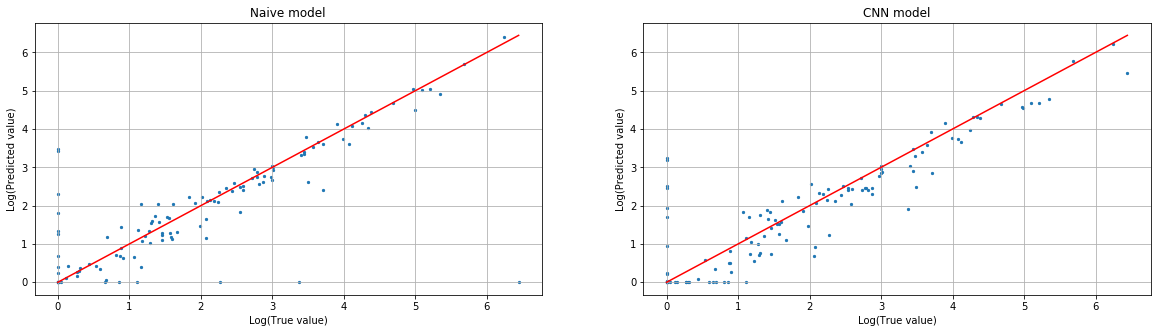

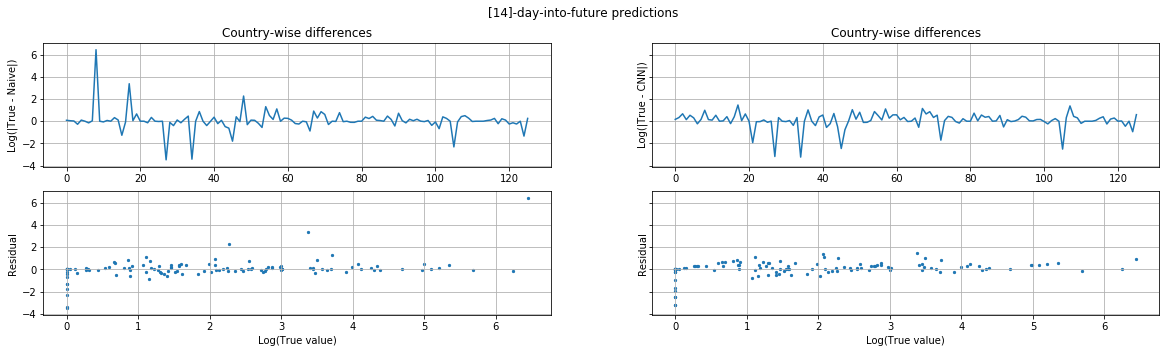

In [103]:
mae_naive = mean_absolute_error(y_test, y_naive)
mae_predict = mean_absolute_error(y_test, y_predict)
r2_naive = explained_variance_score(y_test, y_naive)
r2_predict = explained_variance_score(y_test, y_predict)

print('{}-step MAE [Naive, CNN] = [{},{}]'.format(
n_days_into_future, mae_naive, mae_predict))
print('{}-step R^2 [Naive, CNN] = [{},{}]'.format(
n_days_into_future, r2_naive, r2_predict))

true_predict_plot(y_test, y_naive, y_predict, title='')
residual_diff_plots(y_naive, y_predict, y_test, n_days_into_future, n_countries)

In [83]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 29, 8)             136       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 26, 2)             66        
_________________________________________________________________
flatten_18 (Flatten)         (None, 52)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 52)                2756      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 53        
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


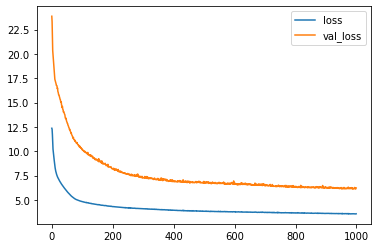

In [84]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

# 7-day prediction

In [85]:
n_days_into_future = [7]
y_test7, y_naive7, y_predict7, model7, history7 = \
                             n_step_model_predictions(model_data, target_data, time_index, model_generator,
                                                      frame_size, start_date, n_countries,
                             n_validation_frames, n_test_frames, n_days_into_future, f, k, epochs, learning_rate, batch_size)

[14]-step MAE [naive7, CNN] = [9.981094588840769,10.863448038559618]
[14]-step R^2 [naive7, CNN] = [0.8305420287882526,0.7936122862207815]


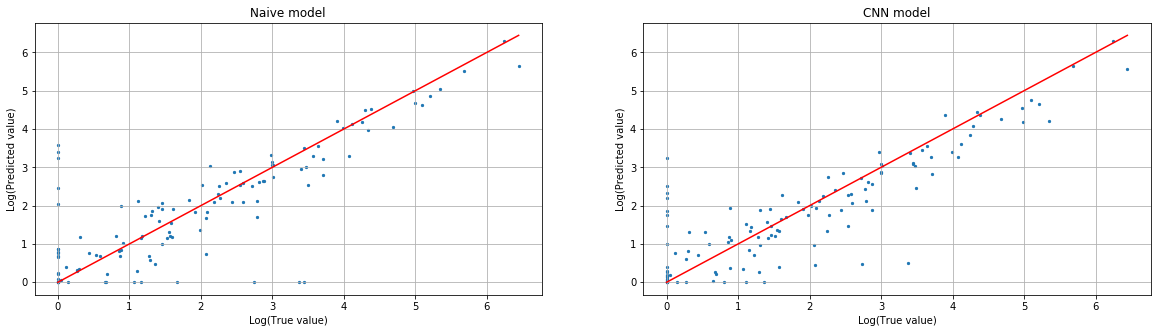

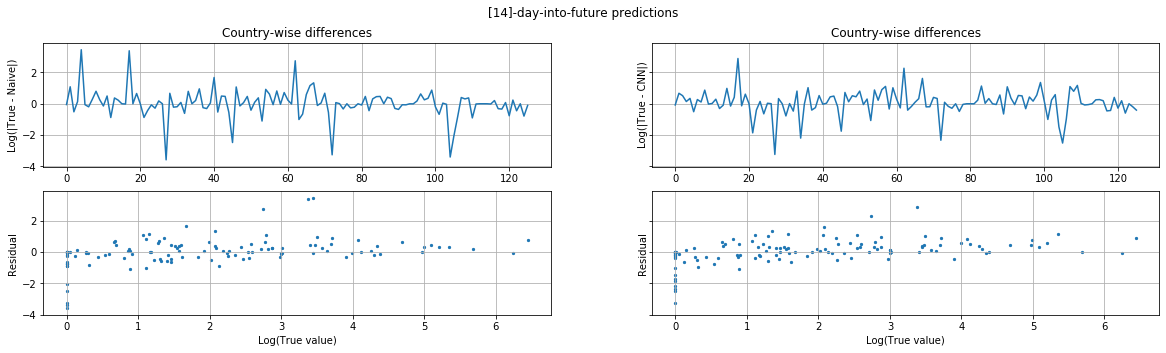

In [104]:
mae_naive7 = mean_absolute_error(y_test7, y_naive7)
mae_predict7 = mean_absolute_error(y_test7, y_predict7)
r2_naive7 = explained_variance_score(y_test7, y_naive7)
r2_predict7 = explained_variance_score(y_test7, y_predict7)

print('{}-step MAE [naive7, CNN] = [{},{}]'.format(
n_days_into_future, mae_naive7, mae_predict7))
print('{}-step R^2 [naive7, CNN] = [{},{}]'.format(
n_days_into_future, r2_naive7, r2_predict7))

true_predict_plot(y_test7, y_naive7, y_predict7, title='')
residual_diff_plots(y_naive7, y_predict7, y_test7, n_days_into_future, n_countries)

In [105]:
model7.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 29, 8)             136       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 26, 2)             66        
_________________________________________________________________
flatten_19 (Flatten)         (None, 52)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 52)                2756      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 53        
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


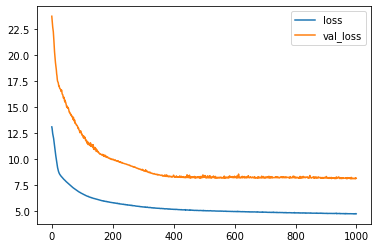

In [106]:
_ = plt.plot(history7.history['loss'], label='loss')
_ = plt.plot(history7.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

# 14-day prediction

In [89]:
n_days_into_future = [14]
y_test14, y_naive14, y_predict14, model14, history14  = \
                             n_step_model_predictions(model_data, target_data, time_index, model_generator,
                                                      frame_size, start_date, n_countries,
                             n_validation_frames, n_test_frames, n_days_into_future, f, k, epochs, learning_rate, batch_size)

[14]-step MAE [naive14, CNN] = [12.337611875286047,15.069932025341439]
[14]-step R^2 [naive14, CNN] = [0.7523881344995227,0.66868271939438]


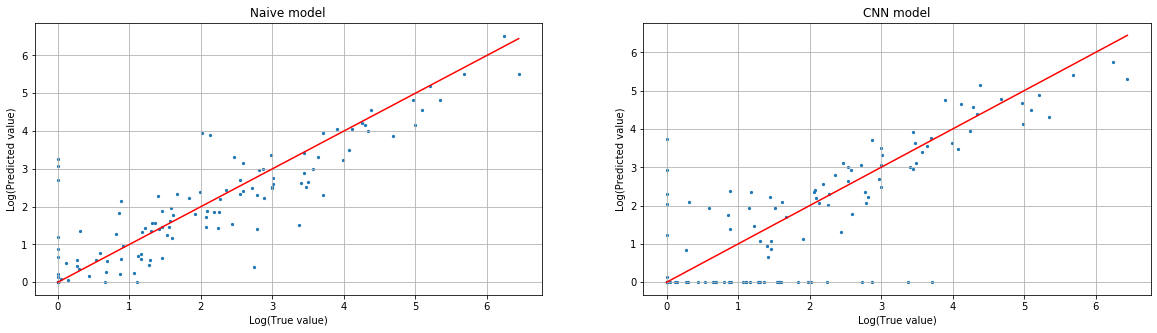

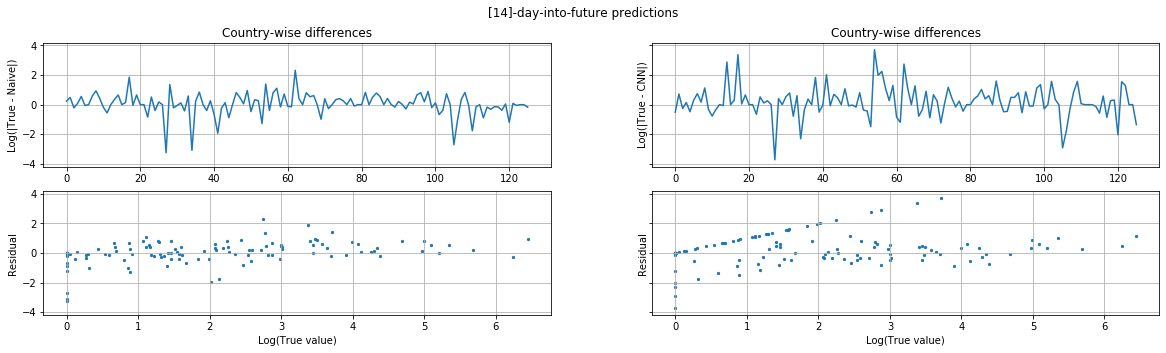

In [107]:
mae_naive14 = mean_absolute_error(y_test14, y_naive14)
mae_predict14 = mean_absolute_error(y_test14, y_predict14)
r2_naive14 = explained_variance_score(y_test14, y_naive14)
r2_predict14 = explained_variance_score(y_test14, y_predict14)

print('{}-step MAE [naive14, CNN] = [{},{}]'.format(
n_days_into_future, mae_naive14, mae_predict14))
print('{}-step R^2 [naive14, CNN] = [{},{}]'.format(
n_days_into_future, r2_naive14, r2_predict14))

true_predict_plot(y_test14, y_naive14, y_predict14, title='')
residual_diff_plots(y_naive14, y_predict14, y_test14, n_days_into_future, n_countries)

In [108]:
model14.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 29, 8)             136       
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 26, 2)             66        
_________________________________________________________________
flatten_20 (Flatten)         (None, 52)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 52)                2756      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 53        
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


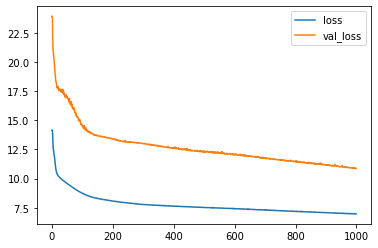

In [109]:
_ = plt.plot(history14.history['loss'], label='loss')
_ = plt.plot(history14.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

In [ ]:
# model.save('CNN_covid_model')

By iterating over possible leading window dates (window right edge, not inclusive),
a 4-d tensor with dimensions given by the following is created:
    
```(n_windows, n_countries, n_time_steps, n_features)```

Even if I don't use the input of this form, it makes it much easier to slice into train, validate and test, by slicing along
the ```n_windows``` axis. 

Note that if I also only wanted to include data from after the first case, that is possible by slicing data.time_index >= 1 

Putting this all together:


Now, splitting X intro train, validate, test, is as easy as slicing the first axis. Depending on how the CNN is set up, this
axis can later be flattened by simply applying ```np.concatenate(X_train, axis=0)```

Now, for the target data ```y```. To be as general as possible, I note that I should first shift the time series and combine them to store all of the data, and THEN manipulate it, i.e.

Assuming that ```X``` is of the shape ```(n_windows, n_countries, n_time_steps, n_features)```, the target data ```y``` should
be of shape ```(n_windows, n_countries)``` and the values for each slice of the first axis is then of shape ```(n_countries,)```, with the values equaling the ```model_data.n_cases_weighted``` value for ```time_index == window_right_edge_inclusive + n```, where n is the prediction step size. 

Because we need future values with which to measure error, the maximum that the leading window edge can be is always 

```model_data.time_index.max() - n```

In other words, because the maximum date value is

If I want to predict (and measure error) for 7 days in the future, the last window would have leading edge 
```model_data.time_index == 123```. 

For now, just test the waters with a 1-day prediction.
To do so, first split the X and y data into train, validate, test.
For the first attempt at a model, use Conv1D only, have to flatten the data with concatenations.
Before this, however, I want to rescale the data. Now, because each different element in the first axis is a different time range, the correct action is to (if normalizing) take the mean with respect to axis=1 and axis=2 ```n_countries``` and  ```n_time_steps```. This leaves a total number of averages of shape ```(n_windows, n_features)```, i.e. the mean and standard deviations for each feature for each date range. This ensures that no data snooping has occurred. To actually subtract and divide by these values, need to reform the same shape array (or at least that seems to be the easiest method to me.

Just to check, the slice [0, :, :, 0] should only contain one value.

Need to normalize only using the values up until frame; in fact, I only use the values inside each frame to normalize.
In the case of normalizing the validation and testing sets, use the most recent frame's means and standard deviation to normalize. This requires forming the correctly shaped array which is performed using np.tile()

Unfortunately there are values (actually a single value) where the standard deviation equals 0. Luckily, this
can be circumvented because the value of $X-\bar{X}$ is zero in the same place; i.e. I set $\sigma=1$ at that location, because
it doesn't actually affect the value.

Notes on results

    1. kernel small->large seems to work ok.
    2. filters
    3. pooling seems to hurt.

Create a 5-d tensor for convolution and FC layer parameters using itertools.
The layers of the CNN will remain the same throughout testing for now. That is, 

    1. Conv1D(f1, k1)
    2. Conv1D(f2, k2)
    3. Flatten
    4. Dense(d)
    5. Dense(1)) 

I don't know enough yet, but my intuition tells me that the overall trend (macroscopic picture)
is much more important to capture than microscopic. 
   
    f1 : number of filters,  first convolutional layer
    k1 : kernel size, first convolutional layer
    f1 : number of filters,  second convolutional layer
    k1 : kernel size, second convolutional layer
    d : number of nodes in hidden fully connected layer
    

I believe the naive baseline is performing so much better simply because of the growth in number of new cases; i.e. the model is training on smaller values and so in every prediction its underestimating. It's also predicting nearly the same values for each separate validation date, likely indicative of overfitting. 

Changing the activations and the layers seems to work much better than the number of filters and kernel size.

ReLU activation on both cd layers somehow increases the values, i.e. away from zero? how does that make sense.
Predicting non-negative quantity -> ReLU at eachy layer, otherwise model will try to use negative values which never do anything?

On the surface this performs worse but doesn't look like it's making ***terrible*** predictions. I'll show that I believe
that the model is indeed over-fitting. 

Relation between X slicing and the original data: 

    X[-1, :, -1, 2] = model_data.time_index.max() - n_days_into_future 
    X[-t, :, -1, 2] = (model_data.time_index.max() - n_days_into_future + 1) - t


### Data Format

Now I will discuss the data format which I have found the most useful. The motivation behind this formatting is that is has to be compatible with keras' convolution layers, respect ordering in time and hopefully be easy to use.

A "sample" or single input of the convolutional model is to be a single time window which I shall refer to as a frame. The output of the model will be a single day's worth of predictions, namely, the next day's number of cases, (with some experimentation into the forecasting range to be performed later). The Conv1D layers require that each sample be of two dimensional input ```(n_time_steps, n_features)```, but the training / testing sets themselves are passed as 3-D tensors of shape ```(all_train_or_test_frames, n_time_steps, n_features)```. In order to partition time in an easy manner, it is easier to first create a 4-D tensor, whose (first) axis can be thought of as indexing the leading edge of the time frames. Therefore, slicing into training, validation and testing, is a well ordered operation simply performed by slicing the tensor along this axis. (picture) ```(n_frames, n_countries, n_time_steps, n_features)```. It is also relatively straight forward how to manipulate the target variables and 

In [ ]:
print(X.shape) 
print(y.shape)

In [ ]:
t = (n_validation_frames + n_test_frames)
new_cases_weighted_index=0
((np.exp(X[-t, :, -1, new_cases_weighted_index])-1) - data[data.time_index == ((data.time_index.max() - n_days_into_future + 1) - t)].new_cases_weighted).sum()

And so to test the baseline, the predictions are of course the date on the RHS + n_days_into_future, or 

This proves the case where n_validate_frames == 1. Now try it for 7. This means that the "first" validation frame is t==8

Ok. Now to see if the baseline is actually what I think it is. There could be an issue into how I am calculating the loss.
This is calculating the loss of all batch frames simulataneously...? Each frame for each country makes a single prediction.
Should I be trying to group it only by frame though? I.e. 2-d input. 

In [ ]:
y_naive = X[-n_test_frames-1, :, -1,  new_cases_weighted_index]

In [ ]:
y - create_Xy(model_data, start_date, frame_size, n_days_into_future, n_countries)[1][-y.shape[0]:]

Somehow the relation between X and y is upheld (because of for loop?) they are not changing between n_days_into_future_changes. 

Emulate the last iteration of for loop.

What should be going on. For n_days_into_future = 7, X should be slicing data from time <= 123

Then, the data is reshaped to be an iterable of sequences of length max_date_in_window, which is then truncated.

For y. What should be happening? 

X is made such that its maximum date is  ```model_data.time_index.max() - n_days_into_future```. So by the very creation of
X, X and y are already staggered if y is sliced correctly. Which would be ```start_date + n_days_into_future : ```, or simply ```-X.shape[0]:```

X_test is the last frame. meaning that it currently contains t-14 information. y_test is the very last day, n_cases_per_million
un-normalized, so the naive model would be simply to use y_predict = X_test_original[:, -1, 2], this takes the values of the feature, new_cases_per_million, on the last day of the frame, for all countries.

SeperableConv2D model. I believe that time steps should be channels and then countries should be the rows...

Suprisingly, my first guess at the parameters was very close to the optimal setup.

In [ ]:
# print('The top 10 sets of parameters (k1,k2,f1,f2,d) are:\n')

# mae_rankings = pd.DataFrame(np.concatenate((parameter_grid[mae_list.argsort()],mae_list[mae_list.argsort()].reshape(-1,1)),axis=1), 
#              columns=['kernel_layer_1','kernel_layer_2','filter_layer_1','filter_layer_2','MAE'])
# mae_rankings.head()


In [ ]:
# mae_rankings.to_csv('conv_parameter_rankings.csv')

# best_param_predictions = predictions_list[mae_list.argsort()][0]

# pd.DataFrame(predictions_list[mae_list.argsort()]).to_csv('model_param_grid_predictions.csv')

In [ ]:
# pd.read_csv('conv_parameter_rankings.csv', index_col=0)

Because ```n_days_into_future == 1```, The most recent date in the last frame of X is data.time_index.max()-1.
The maximum date in y is data.time_index().max(). Therefore, to convert, we have
    
    X[-1,:,-1,:] = y[-2, :]
    
or, more generally, 

    X[-t,:,-1,:] = y[-(n+t), :]
    
testing this:

In [ ]:
# last_day_in_X = -1
# if last_day_in_X == -1:
#     last_day_in_X = None
# X_test_original = X[-16:last_day_in_X, :, -1, new_cases_weighted_index] 
# if last_day_in_X is None:
#     last_day_in_X = 0

# X_test_original - y[-(n_test_frames+n_days_into_future+X_test_original.shape[0]+last_day_in_X-1):
#                     -(n_days_into_future+last_day_in_X), :]

This shows that the staggering has been done correctly. That is, each entry along the first axis of X predicts.
Need to make sure that the naive predictions are being chosen correctly. To do so, just look at the instance
where n_frames_validation == 1 and n_frames_test == 1 (to make slicing easier) for n_days_into_future == 7.

Specifically, the shifting and comparison between y_validate and X_train isn't so hard as it follows the above formula.
This is prior to concatenation / squeezing / flattening the first axis.

    The following holds but this is not the predictions relation:   X[-t,:,-1,:] = y[-(n+t), :]
                                                  
    y has already been shifted to account for the n_days_into_future prediction. Therefore,     
    True future new_cases_weighted values : y[-t,:]. This is the n_days_into_future values.
    
    CNN predictions new_cases_weighted : model.predict(X[-t, :, :, :]). This predicts using the "present day" frame. 
    
    Naive predictions new_cases_weighted values: X[-t,:,-1, 2]. This takes the present day value from the last values of the frames.

Therefore, when n_validation_frames > 1.  are simply

    Naive predictions = X[validation_indices, :, -1, 2]
    CNN predictions = model.predict(X[validation_indices, :, :, :])
    True future values = y[validation_indices, :]
    
    Where validation indices is assumed to be a correctly formatted array of negative indices. 
    
    
    The last issue is the fact that X_validate is normalized and y values are not. Therefore, for the prediction X_validate is used, but for the naive baseline either the inverse normalized X_validation or just the original X should be used. Original
    X is actually easier because of 4-d index.

First, train and "test" without using the holdout test set. i.e. just use train and validation sets to test
This uses a single frame to validate (and test). Therefore, the naive model is formed by taking the frame of
X_validate and using its values for the prediction. The true values are stored in y_validate, the predicted values
are formed by using X_validate to predict, the naive values are the values in X_validate. 

Remember when slicing, the n_days_into_future buffer has already been factored into account. i.e. test
slicing is X[-n_test_frames:,:,:,:]

X time_index 130 is not used. X_test is 129, y_test is 130. X_validate is 126,127,128 y is 127,128,129.

In [ ]:
np.sqrt(1./(X_train.shape[0]/32))

from https://papers.nips.cc/paper/7320-how-many-samples-are-needed-to-estimate-a-convolutional-neural-network.pdf

To achieve error $\epsilon$ with filter number $m$ the number of samples needed is $\mathcal{O}(m/\epsilon^2)$

Let $\epsilon = 0.1$, then $100m$ = samples or $m = samples/100$. The number of samples is

It seems that included information from the too distant past actually makes the model worse. 

switching the order of countries and timesteps affects the following:
reshape A
kernel size B
kernal size AB
concatenate axis 1->2

If you have a convolution model. How is choosing a smaller frame size + kernel size different from
larger

The above model is the *only* one that hasn't underestimated values. There is still a lot of parameter tuning to be completed though:

The performance is the same up to small differences attributable to the individual trainings. 

In both models, the key difference between the predictions and the true values is that the ConvNet is having a hard
time picking up on dramatic spikes in the number of new cases. 

Archived results

## 8-2//4

1-step MAE [Naive, CNN] = [10.181423289216637,9.683242379442238]
1-step R^2 [Naive, CNN] = [0.5095423321692748,0.7953289844554481]


## 8-2//full

1-step MAE [Naive, CNN] = [10.181423289216637,8.567139680099809]
1-step R^2 [Naive, CNN] = [0.5095423321692748,0.8559826950197971]

## 8-2//8

1-step MAE [Naive, CNN] = [10.181423289216637,11.227516786392403]
1-step R^2 [Naive, CNN] = [0.5095423321692748,0.7102283800705309]

## 8-2//2

1-step MAE [Naive, CNN] = [10.181423289216637,8.873572600787506]
1-step R^2 [Naive, CNN] = [0.5095423321692748,0.7925219254301763]

## 8-4//full
1-step MAE [Naive, CNN] = [10.181423289216637,9.362758538127283]
1-step R^2 [Naive, CNN] = [0.5095423321692748,0.7841815468693817]

## 4-2//full

1-step MAE [Naive, CNN] = [10.181423289216637,9.758042888093435]
1-step R^2 [Naive, CNN] = [0.5095423321692748,0.8573291582800996]

## 8-2//2 10k

1-step MAE [Naive, CNN] = [10.181423289216637,8.977670771914049]
1-step R^2 [Naive, CNN] = [0.5095423321692748,0.8255246499845381]